In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 Super (UUID: GPU-abd3a994-bcca-3201-8521-c1a99878d05a)


In [2]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install DALL-E
!pip install ftfy
!pip install imageio
!git clone https://github.com/openai/CLIP.git
%cd CLIP/

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
fatal: destination path 'CLIP' already exists and is not an empty directory.
/home/ubuntu20/workspace/github/dalle2/CLIP


In [3]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import PIL
import matplotlib.pyplot as plt
import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
import glob
#from google.colab import output
InteractiveShell.ast_node_interactivity = "all"

# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')

/home/ubuntu20/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import clip
clip.available_models()

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
import io
import os, sys
import requests
import PIL
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from dall_e import map_pixels, unmap_pixels, load_model

target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')

In [6]:
text_input = "a cute cat" 
tau_value =1.2

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


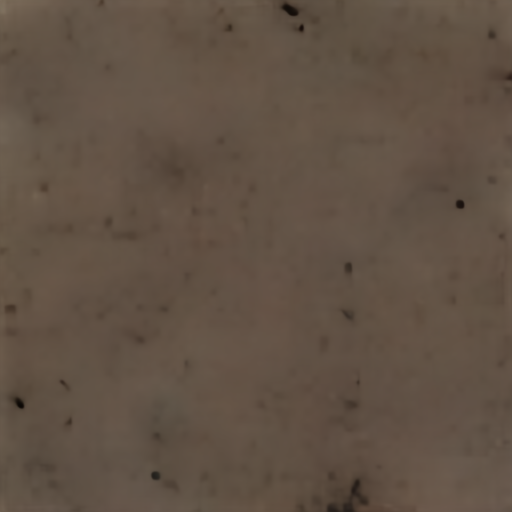

In [7]:
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())

    def forward(self):
      # normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)
      normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1, tau=tau_value).view(1, 8192, 64, 64)
      return normu

lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
eps = 0
tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()
nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

with torch.no_grad():
  mult = 1
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')
  # print(torch.topk(lats().view(1, 8192, -1), k=3, dim=-1))

/home/ubuntu20/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


##########################################################  [0, tensor([-2.1426], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 0


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


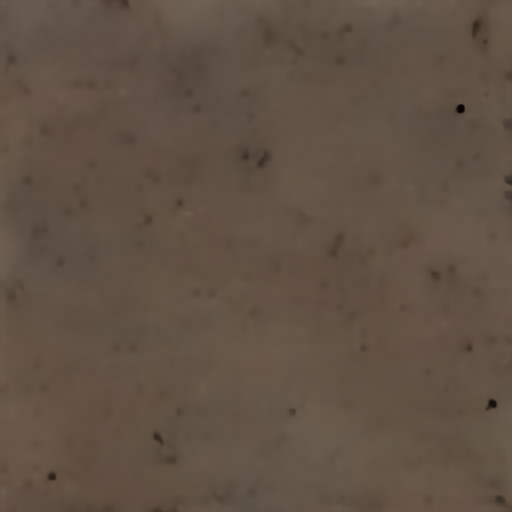



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.3379], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 100


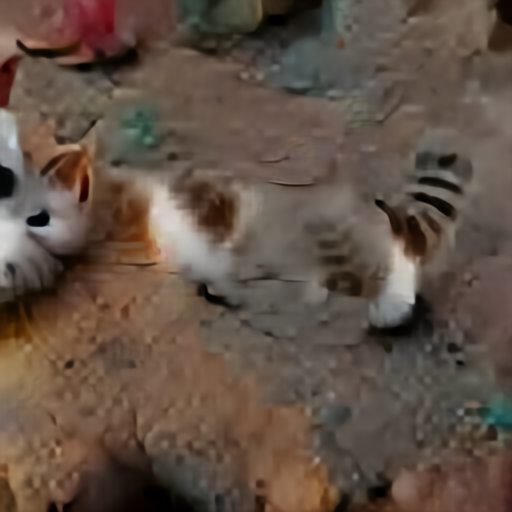



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.5273], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 200


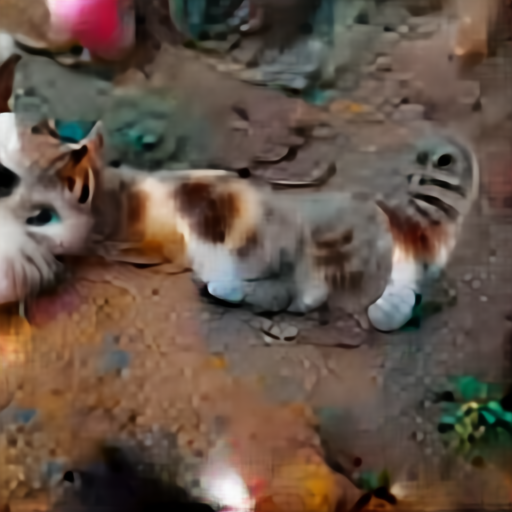



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.4492], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 300


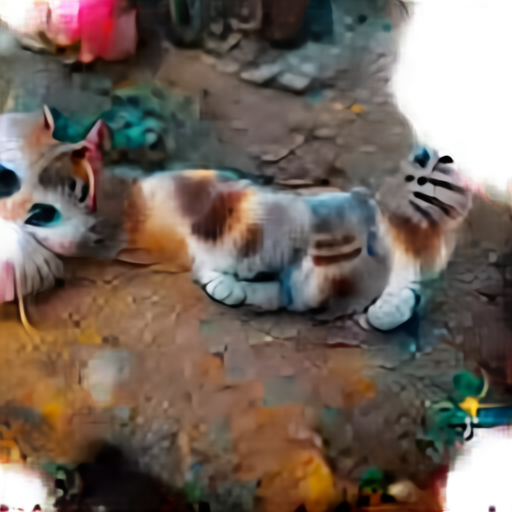



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.5742], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 400


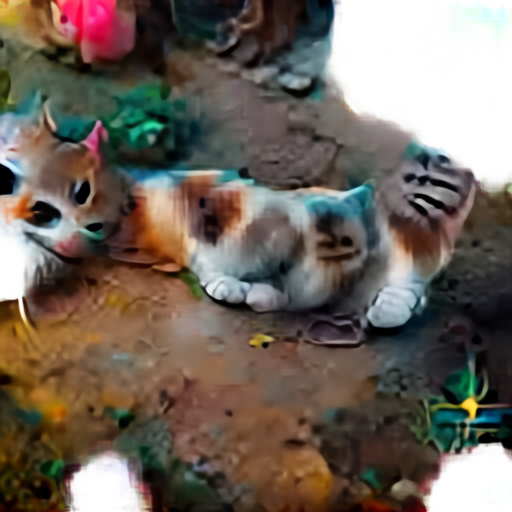



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.6211], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 500


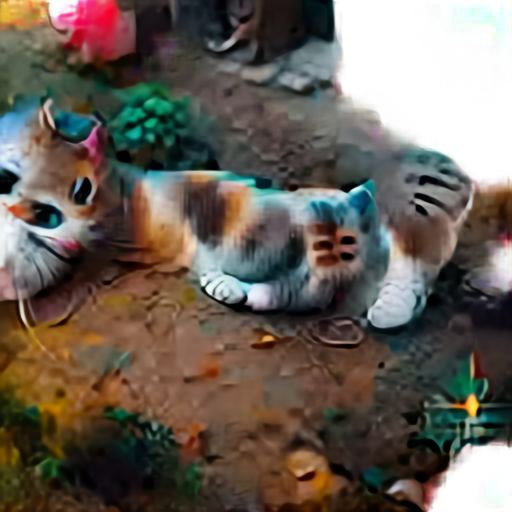



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.6641], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 600


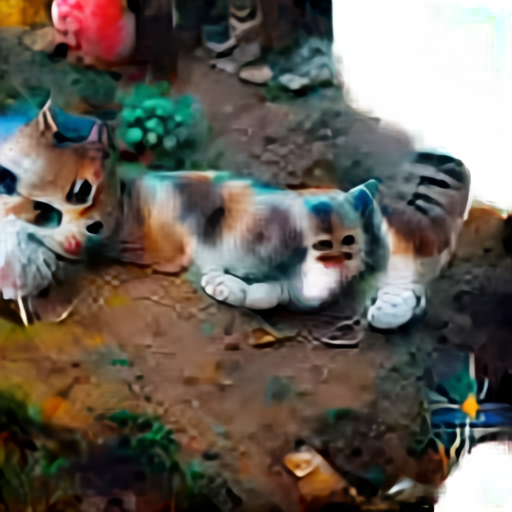



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.7344], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 700


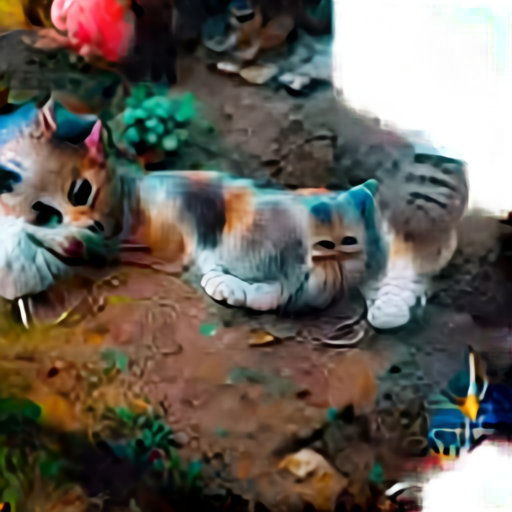



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.7383], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 800


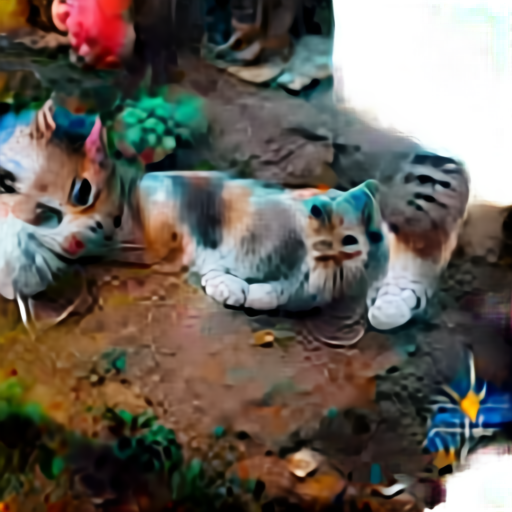



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.7285], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 900


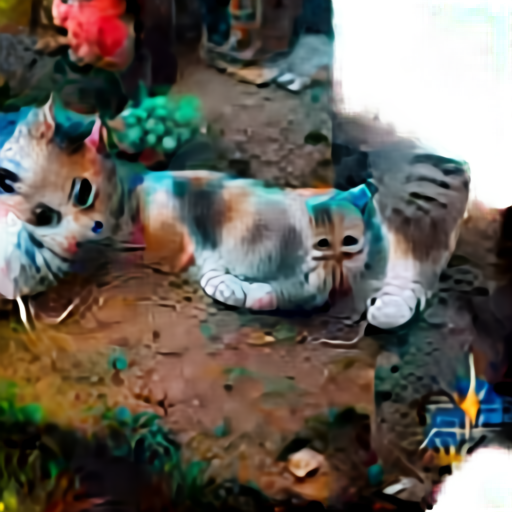



##########################################################  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[0, tensor([-3.8867], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 1000


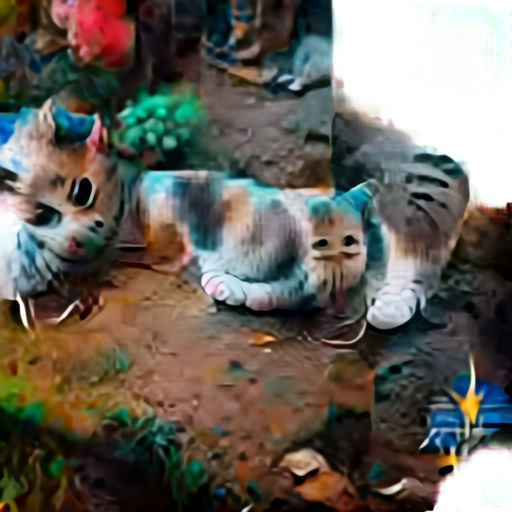

In [8]:
def checkin(loss):
  print('''########################################################## ''',loss, '\n',itt)
  
  with torch.no_grad():
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  # the people spoke and they love "ding"
  # output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))
  cutn = 64 # improves quality
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')
  into = nom(into)
  iii = perceptor.encode_image(into)
  llls = lats()
  lat_l = 0
  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]

def train(i):
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
  if itt % 100 == 0:
    checkin(loss1)
    shutil.copy('./3.png', './images/%s.png'%str(int(itt/100)).zfill(6))

import shutil

if os.path.isdir('images'):
    shutil.rmtree('images')
os.makedirs('images', exist_ok=True)

itt = 0
for asatreat in range(1100):
  train(itt)
  itt+=1

In [ ]:
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

!ffmpeg -r 2 -i images/%06d.png -vcodec libx264 -pix_fmt yuv420p output.mp4